# Goal
This post aims to break down the module [`dtreeviz`](https://github.com/parrt/dtreeviz) module step by step to fully understand what is implemented. After fully understanding this, I would like to contribute to this module and submit a pull request. 

I really like this module and would like to see this works for other tree-based modules like XGBoost or Lightgbm. I found [the exact same issue (issues 15)](https://github.com/parrt/dtreeviz/issues/15) in github so I hope I could contribute to this issue.

This post is the 3rd part: breaking down `ShadowDecTree`. 

**Reference**
* [Github dtreeviz](https://github.com/parrt/dtreeviz)
* [Step by Step Data Science - Split-Up: dtreeviz (Part 1)](https://h1ros.github.io/posts/split-up-dtreeviz-part-1/)
* [Step by Step Data Science - Split-Up: dtreeviz (Part 2)](https://h1ros.github.io/posts/split-up-dtreeviz-part-2/)
* [Scikit-Learn - Tree](https://scikit-learn.org/stable/modules/tree.html)
 

# `ShadowDecTreeNode` class

## Source [github](https://github.com/parrt/dtreeviz/blob/master/dtreeviz/shadow.py)



In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict, Sequence
from typing import Mapping, List, Tuple
from numbers import Number
from sklearn.utils import compute_class_weight

from dtreeviz.shadow import ShadowDecTree 
# skip ShadowDecTree Class
#

class ShadowDecTreeNode:
    """
    A node in a shadow tree.  Each node has left and right
    pointers to child nodes, if any.  As part of tree construction process, the
    samples examined at each decision node or at each leaf node are
    saved into field node_samples.
    """
    def __init__(self, shadow_tree, id, left=None, right=None):
        self.shadow_tree = shadow_tree
        self.id = id
        self.left = left
        self.right = right

    def split(self) -> (int,float):
        return self.shadow_tree.tree_model.tree_.threshold[self.id]

    def feature(self) -> int:
        return self.shadow_tree.tree_model.tree_.feature[self.id]

    def feature_name(self) -> (str,None):
        if self.shadow_tree.feature_names is not None:
            return self.shadow_tree.feature_names[ self.feature()]
        return None

    def samples(self) -> List[int]:
        """
        Return a list of sample indexes associated with this node. If this is a
        leaf node, it indicates the samples used to compute the predicted value
        or class.  If this is an internal node, it is the number of samples used
        to compute the split point.
        """
        return self.shadow_tree.node_to_samples[self.id]

    def nsamples(self) -> int:
        """
        Return the number of samples associated with this node. If this is a
        leaf node, it indicates the samples used to compute the predicted value
        or class. If this is an internal node, it is the number of samples used
        to compute the split point.
        """
        return self.shadow_tree.tree_model.tree_.n_node_samples[self.id] # same as len(self.node_samples)

    def split_samples(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Return the list of indexes to the left and the right of the split value.
        """
        samples = np.array(self.samples())
        node_X_data = self.shadow_tree.X_train[samples, self.feature()]
        split = self.split()
        left = np.nonzero(node_X_data < split)[0]
        right = np.nonzero(node_X_data >= split)[0]
        return left, right

    def isleaf(self) -> bool:
        return self.left is None and self.right is None

    def isclassifier(self):
        return self.shadow_tree.tree_model.tree_.n_classes > 1

    def prediction(self) -> (Number,None):
        """
        If this is a leaf node, return the predicted continuous value, if this is a
        regressor, or the class number, if this is a classifier.
        """
        if not self.isleaf(): return None
        if self.isclassifier():
            counts = np.array(self.shadow_tree.tree_model.tree_.value[self.id][0])
            predicted_class = np.argmax(counts)
            return predicted_class
        else:
            return self.shadow_tree.tree_model.tree_.value[self.id][0][0]

    def prediction_name(self) -> (str,None):
        """
        If the tree model is a classifier and we know the class names,
        return the class name associated with the prediction for this leaf node.
        Return prediction class or value otherwise.
        """
        if self.isclassifier():
            if self.shadow_tree.class_names is not None:
                return self.shadow_tree.class_names[self.prediction()]
        return self.prediction()

    def class_counts(self) -> (List[int],None):
        """
        If this tree model is a classifier, return a list with the count
        associated with each class.
        """
        if self.isclassifier():
            if self.shadow_tree.class_weight is None:
                return np.array(np.round(self.shadow_tree.tree_model.tree_.value[self.id][0]), dtype=int)
            else:
                return np.round(self.shadow_tree.tree_model.tree_.value[self.id][0]/self.shadow_tree.class_weights).astype(int)
        return None

    def __str__(self):
        if self.left is None and self.right is None:
            return "<pred={value},n={n}>".format(value=round(self.prediction(),1), n=self.nsamples())
        else:
            return "({f}@{s} {left} {right})".format(f=self.feature_name(),
                                                     s=round(self.split(),1),
                                                     left=self.left if self.left is not None else '',
                                                     right=self.right if self.right is not None else '')


## Instantiate class objects

### Create a tree model by scikit learn


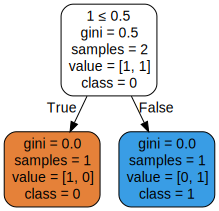

In [3]:
import numpy as np
import graphviz 
from sklearn import tree

X = np.array([[0, 0], [1, 1]])
Y = np.array([0, 1])
# Y = [0, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=[0, 1],  
                     class_names=['0', '1'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 


## Create a `ShadowDecTreeNode`

**ShadowDecTreeNode** `__init__`
- L222-226: store input arguments as class members
- L228-308: define the same functions in tree objects like `split`, `feature` etc. or utility functions



In [4]:
# instantiate ShadowDecTree
shadow_tree = ShadowDecTree(tree_model=clf, X_train=X, y_train=Y, feature_names=[0, 1], class_names=[0, 1])

In [5]:
# instantiate ShadowDecTreeNode
shadow_tree_node0 = ShadowDecTreeNode(shadow_tree=shadow_tree, id=0)
shadow_tree_node0

## Methods under ``ShadowTreeDecNode

In [6]:
# L228 split
shadow_tree_node0.split()

0.5

In [7]:
# L231 feature
shadow_tree_node0.feature()

1

In [8]:
# L239 samples
shadow_tree_node0.samples()

[0, 1]

In [9]:
# L248 nsamples
shadow_tree_node0.nsamples()

2

In [10]:
# L257 split_samples
shadow_tree_node0.split_samples()

(array([0]), array([1]))

In [11]:
# L268 isleaf
shadow_tree_node0.isleaf()

True

In [12]:
# L271 isclassifier
shadow_tree_node0.isclassifier()

array([ True])

In [13]:
# L287 prediction_name
shadow_tree_node0.prediction_name()

0

In [14]:
# L298 class_counts
shadow_tree_node0.class_counts()

array([1, 1])